# Анализ оттока клиентов банка

Мы работаем в одном из лучших банков страны «Метанпромбанке»

Задача нашего исследования проанализировать клиентов банка. Анализ покажет, как клиенты пользуются нашими услугами, а так же поможет нам составить портрет клиентов, которые склонны уходить из банка.

Цель исследования - на основе полученных данных сформулировать предложения, которые помогут сократить отток клиентов.

## Откроем файл с данными и изучим общую информацию.

In [1]:
# импортируем библиотеки
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import scipy.stats as st
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from plotly import graph_objects as go
import plotly.express as px
import math as mth


In [2]:
# считаем данные из csv-файла в датафрейм и сохраним в соответствующую переменную
df = pd.read_csv('https://code.s3.yandex.net/datasets/bank_dataset.csv')

In [3]:
# выводим первые 5 строк
df.head()  

userid  score       City Gender  Age  Objects    Balance  Products  \
0  15677338    619  Ярославль      Ж   42        2        NaN         1   
1  15690047    608    Рыбинск      Ж   41        1   83807.86         1   
2  15662040    502  Ярославль      Ж   42        8  159660.80         3   
3  15744090    699  Ярославль      Ж   39        1        NaN         2   
4  15780624    850    Рыбинск      Ж   43        2  125510.82         1   

   CreditCard  Loyalty  estimated_salary  Churn  
0           1        1         101348.88      1  
1           0        1         112542.58      0  
2           1        0         113931.57      1  
3           0        0          93826.63      0  
4           1        1          79084.10      0

In [4]:
# выводим основную информацию о датафрейме с помощью метода info()
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


## Предобработка данных

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск. Мы располагаем данными за февраль 2023 года.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.


На данном этапе планируется проделать следующую работу:

- изменить написание заголовков столбцов
- проверить на наличие дубликатов
- проверить на наличие пропусков 

In [5]:
# приведение к нижнему регистру названия столбцов
df.columns = df.columns.str.lower() 

In [6]:
# меняем названия столбцов
df = df.rename(columns={'userid':'user_id','creditcard':'credit_card'})

In [7]:
# проверим результат
df.head()

user_id  score       city gender  age  objects    balance  products  \
0  15677338    619  Ярославль      Ж   42        2        NaN         1   
1  15690047    608    Рыбинск      Ж   41        1   83807.86         1   
2  15662040    502  Ярославль      Ж   42        8  159660.80         3   
3  15744090    699  Ярославль      Ж   39        1        NaN         2   
4  15780624    850    Рыбинск      Ж   43        2  125510.82         1   

   credit_card  loyalty  estimated_salary  churn  
0            1        1         101348.88      1  
1            0        1         112542.58      0  
2            1        0         113931.57      1  
3            0        0          93826.63      0  
4            1        1          79084.10      0

Проверим на наличие дубликатов и пропусков

In [8]:
# проверка наличия дубликатов
df.duplicated().sum()  

0

In [9]:
# подсчёт пропусков
df.isna().sum() 

user_id                0
score                  0
city                   0
gender                 0
age                    0
objects                0
balance             3617
products               0
credit_card            0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

Мы видим что пропущены 3 617 значений в столбце Баланс(36,17%). 

Думаю это может означать отсутствие средств на карте, в таком случае пропуски можно заменить на 0, но в таком случае смущает количество пропусков - 36,17% очень много для 0-го баланса. Так же пропуски могли возникнуть из-за ошибки при выгрузке данных,предлагаю оставить пропуски как есть, т.к. некачественная замена пропусков может принести больше вреда чем пользы.

## Исследовательский анализ данных

### Для начала изучим числовое описание данных

In [10]:
# получаем числовое описание данных методом describe
df.describe().T.round() 

count        mean      std         min         25%  \
user_id           10000.0  15733677.0  71936.0  15608437.0  15671264.0   
score             10000.0       651.0     97.0       350.0       584.0   
age               10000.0        39.0     10.0        18.0        32.0   
objects           10000.0         5.0      3.0         0.0         3.0   
balance            6383.0    119827.0  30095.0      3769.0    100182.0   
products          10000.0         2.0      1.0         1.0         1.0   
credit_card       10000.0         1.0      0.0         0.0         0.0   
loyalty           10000.0         1.0      0.0         0.0         0.0   
estimated_salary  10000.0    100090.0  57510.0        12.0     51002.0   
churn             10000.0         0.0      0.0         0.0         0.0   

                         50%         75%         max  
user_id           15733474.0  15795970.0  15858426.0  
score                  652.0       718.0       850.0  
age                     37.0        44.0        92.0  
objects                  5.0         7.0        10.0  
balance             119840.0    139512.0    250898.0  
products                 1.0         2.0         4.0  
credit_card              1.0         1.0         1.0  
loyalty                  1.0         1.0         1.0  
estimated_salary    100194.0    149388.0    199992.0  
churn                    0.0         0.0         1.0

Видим что кредитный рейтинг в среднем составляет 651 (медианное значение 652), что является оптимальным показателем для заемщика.

Для лучшего понимания, шкала кредитного рейтинга условно выглядит следующим образом:

0 — 300 баллов: получить кредит практически невозможно.

500 — 600 баллов: вероятность получения кредита крайне мала.

600 — 640 баллов: получение кредита возможно, но не гарантировано.

640 — 650 баллов: хорошие шансы на получение кредита.

650 — 690 баллов: оптимальный скоринг заемщика.

690 - 850 баллов: вероятность отказа крайне мала.

Возраст клиентов преимущественно в диапазоне от 32 до 44 лет

В среднем клиенты имеют 5 объектов в собственности

Среднее количество используемых продуктов банка - 2

Средний уровень дохода порядка 100 тыс.

### Построим графики распределения

Для начала рассмотрим соотношение отточных и не отточных клиентов 

Напомню, что необходимая информация хранится в столбце churn, где:

0 — клиент остался

1 — клиент ушел

In [11]:
#выводим уникальные значения и их количество по частоте упоминания
df_churn = df['churn'].value_counts().reset_index() 
df_churn['index'] =df_churn['index'].replace(0,'клиент остался') 
df_churn['index'] =df_churn['index'].replace(1,'клиент ушел') 

In [12]:
# строим диаграмму с сегментами
fig = go.Figure(data=[go.Pie(labels=df_churn['index'], 
                             values=df_churn['churn'], 
                             pull = [0.1, 0])]) 
fig.update_layout(title='Соотношение отточных и не отточных клиентов', 
                  width=800, 
                  height=600,
                  annotations=[dict(x=1.12, 
                                    y=1.05,
                                    text='Статус клиента',
                                    showarrow=False)])
fig.show() 

Мы видим что за месяц ушло 20,4% клиентов, это достаточно большой показатель. Посмотрим распределение признаков для отточных и не отточных клиентов

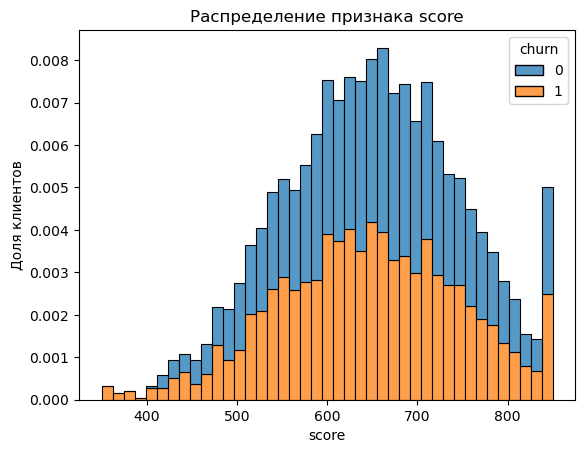

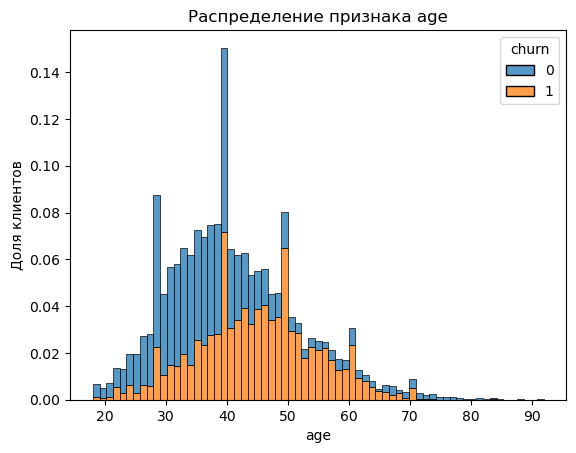

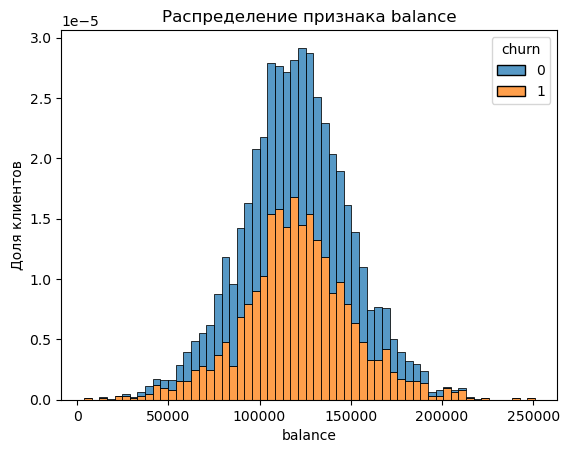

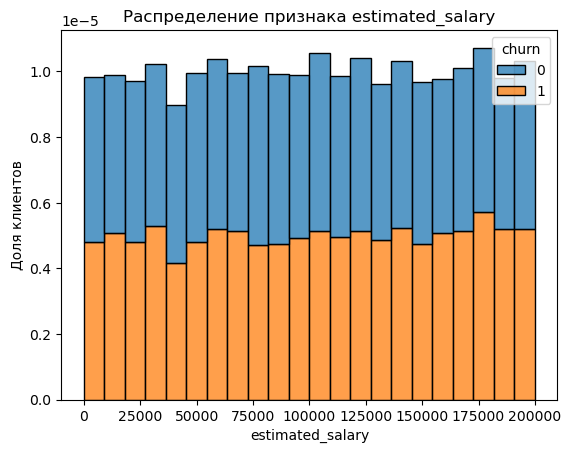

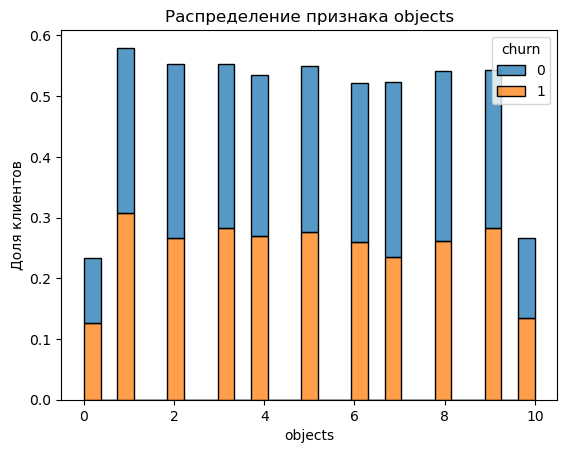

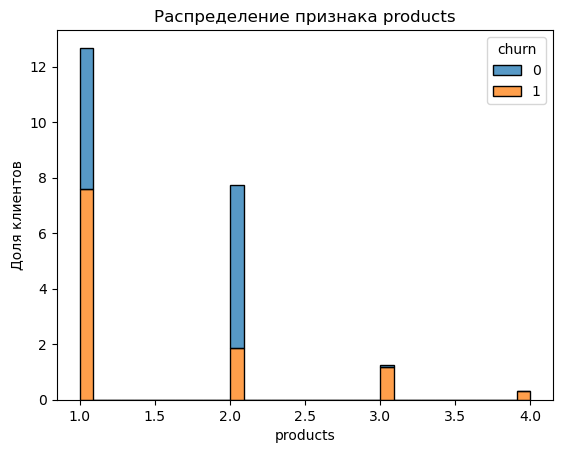

In [13]:
# строим гистограммы распределения по каждому из признаков
columns_histplot = ['score', 'age', 'balance', 'estimated_salary', 'objects', 'products']
for column in columns_histplot :  
    sb.histplot(data = df,x=column,hue='churn',multiple="stack", stat = 'density', common_norm = False)
    plt.title(f"Распределение признака {column}")
    plt.xlabel(column)
    plt.ylabel('Доля клиентов')
    plt.show()

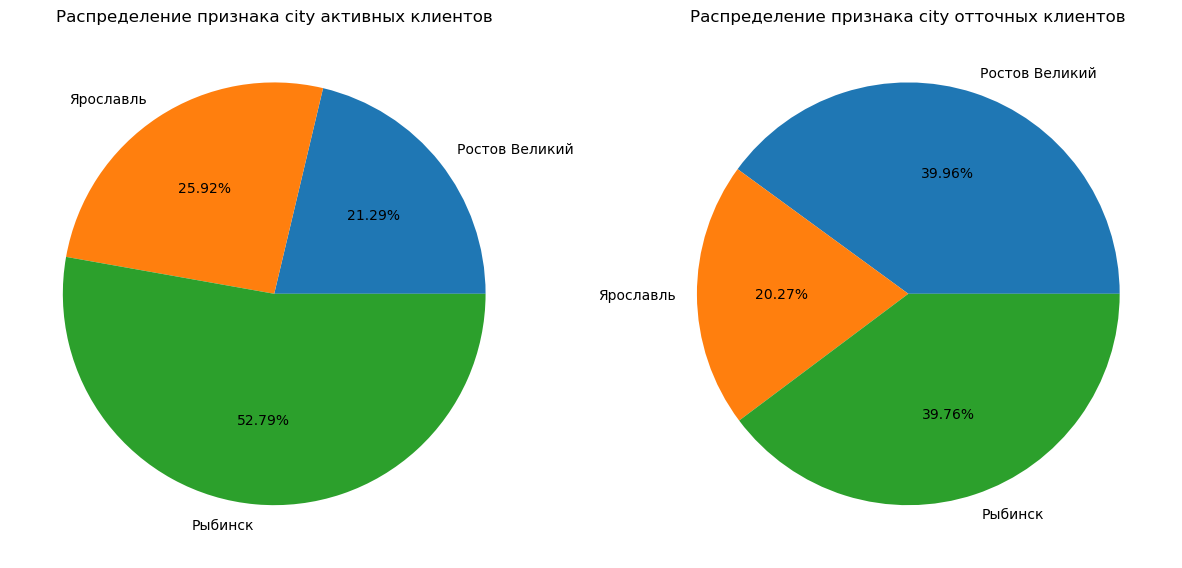

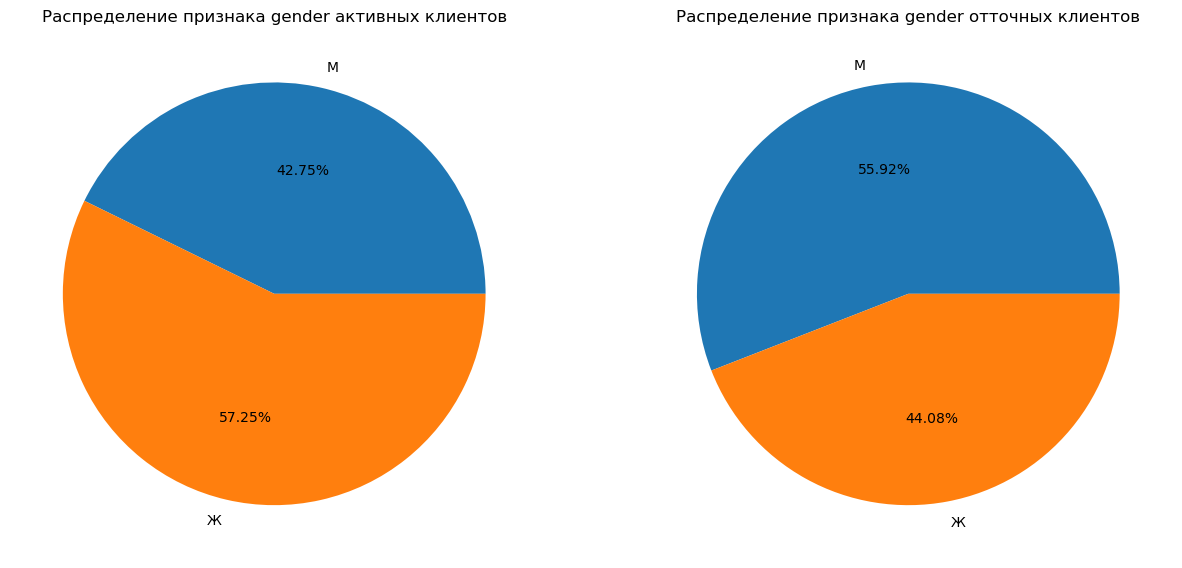

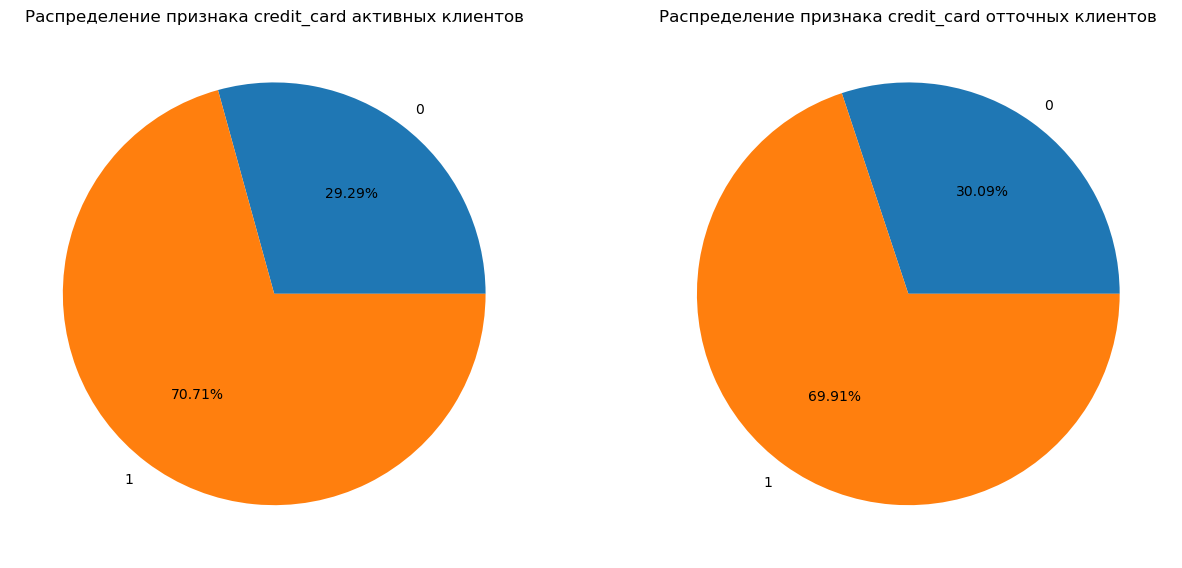

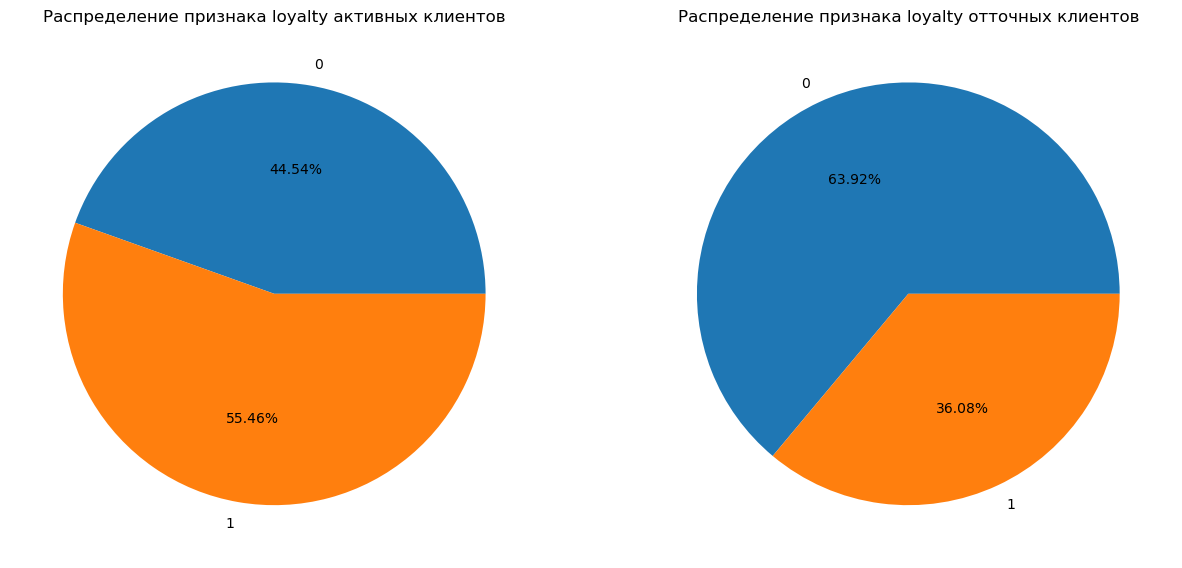

In [14]:
# строим диаграмму с сегментами по каждому из признаков
columns_pie = ['city', 'gender', 'credit_card', 'loyalty']
for column in columns_pie:  
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    axs[0].pie(df.query('churn == 0').groupby(column)['user_id'].count(),
               labels = set(df[column]), autopct = '%1.2f%%')
    axs[0].set_title(f"Распределение признака {column} активных клиентов")
    axs[1].pie(df.query('churn == 1').groupby(column)['user_id'].count(), 
               labels = set(df[column]), autopct = '%1.2f%%')
    axs[1].set_title(f"Распределение признака {column} отточных клиентов")
    

По графикам можно сделать следующие выводы:

- распределение кредитного рейтинга равномерно, клиенты с низким скорринговым баллом (400 и ниже) отточные. Достаточно большое количество клиентов в обеих группах имеют наивысший кредитный рейтинг

- бОльшая часть клиентов находится в Ярославле, в Рыбинске и Ростове Великом примерно одинаковое количество клоиентов, однако отток выше в Ростове Великом

- клиентов мужчин больше чем женщин, однако отточных клиентов больше женщин

- преобладают клиенты в возрасте до 55 лет, среди отточных больше клиентов в диапазоне 40 - 50 лет

- количество объектов пользователей распределено равномерно, взаимосвязь количества объектов и оттока клиента не прослеживается

- баланс на счетах клиентов находится преимущественно в диапазоне 100 - 150 тыс, в обеих группах клиентов, клиенты с балансом более 200 тыс. по большей части отточные

- преимущественно у клиентов банка 1-2 продукта. Уходят чаще пользователи с 1 продуктом, среди тех пользователей у кого 3-4 продукта большинство ушли

- у большинства клиентов банка имеются кредитные карты, при этом сложно сказать о влиянии  наличия кредитки на отток

- чаще уходят не активные клименты

- заработная плата клиентов распределена равномерно, взаимосвязь с оттоком клиентов не прослежитвается.

### Проведем корреляционный анализ

Переведем категориальные переменные в бинарный формат, для дальнейшего анализа

In [15]:
# переводим пол в бинарный формат, где 0 - женщина, 1 -мужчина
df_corr = pd.get_dummies(df, columns=['gender'], drop_first= True )

In [16]:
# выделяем столбцы с городами в бинарном формате
df_corr = pd.get_dummies(df_corr, columns=['city'], drop_first= False ) 

Переименуем образовавшиеся столбцы

In [17]:
# меняем названия столбцов
df_corr = df_corr.rename(columns={'gender_М':'gender','city_Ростов Великий':'rostov', 
                                  'city_Рыбинск':'rybinsk', 'city_Ярославль':'yaroslavl'}) 

In [18]:
# строим корреляционную матрицу
df_corr.drop('user_id', axis=1).corr().style.background_gradient(cmap = 'coolwarm')

Для оценки силы связи в теории корреляции применяется шкала английского статистика Чеддока:

слабая — от 0,1 до 0,3; 

умеренная — от 0,3 до 0,5; 

заметная — от 0,5 до 0,7; 

высокая — от 0,7 до 0,9; 

весьма высокая (сильная) — от 0,9 до 1,0.

В соответствии с данной Шкалой можем отметить что между переменными преимущественно слабая связь.

## Составление портрета клиента

На этапе исследовательского анализа мы заметили что больше всего отточных клиентов:
- в Ростове Великом
- женщин
- в диапазоне 40 - 50 лет
- с 1, или 3-4 продуктами

Посмотрим на данные в разрезе данных параметров

### Анализ оттока в разрезе городов

In [19]:
# сводная таблица по городам
df.pivot_table(index='city', columns='churn',values='user_id',aggfunc='count')

churn              0    1
city                     
Ростов Великий  1695  814
Рыбинск         2064  413
Ярославль       4204  810

Как мы отметили ранее бОльшая часть клиентов находится в Ярославле, в Рыбинске и Ростове Великом примерно одинаковое количество клиентов,

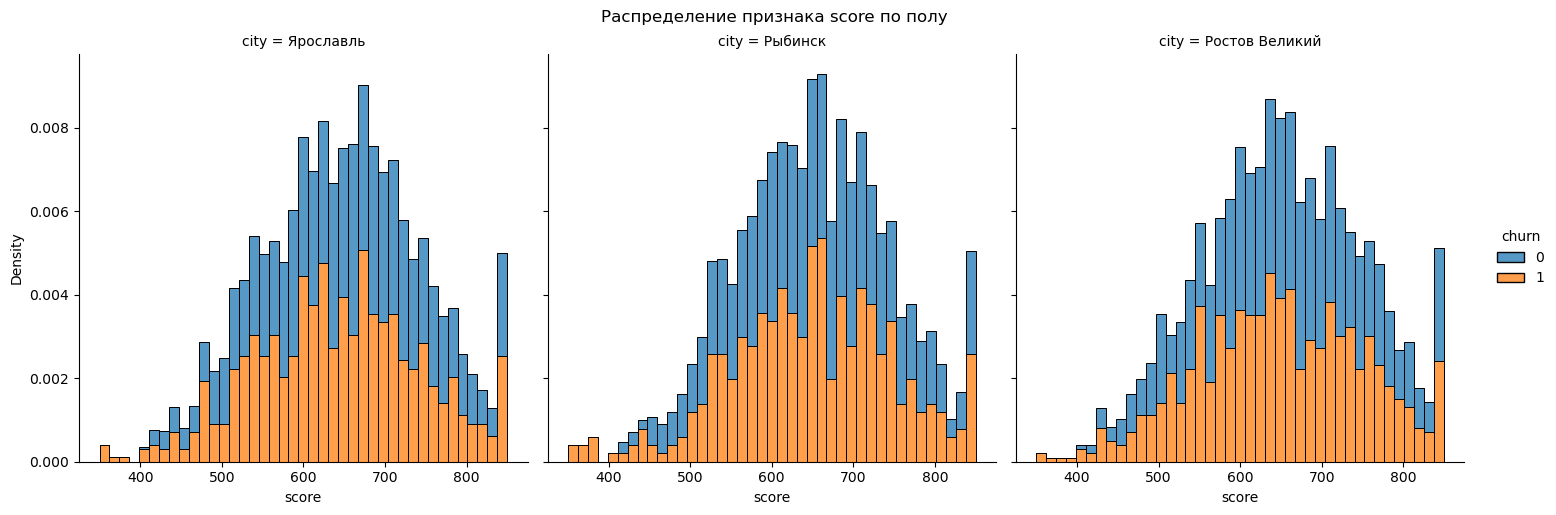

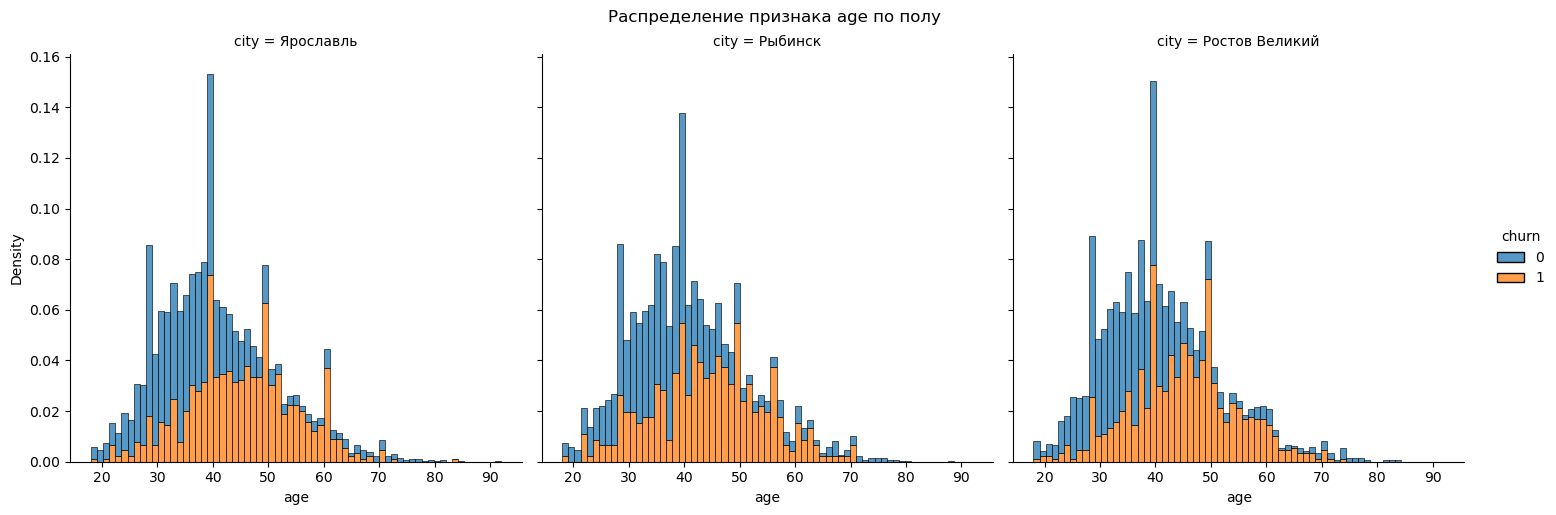

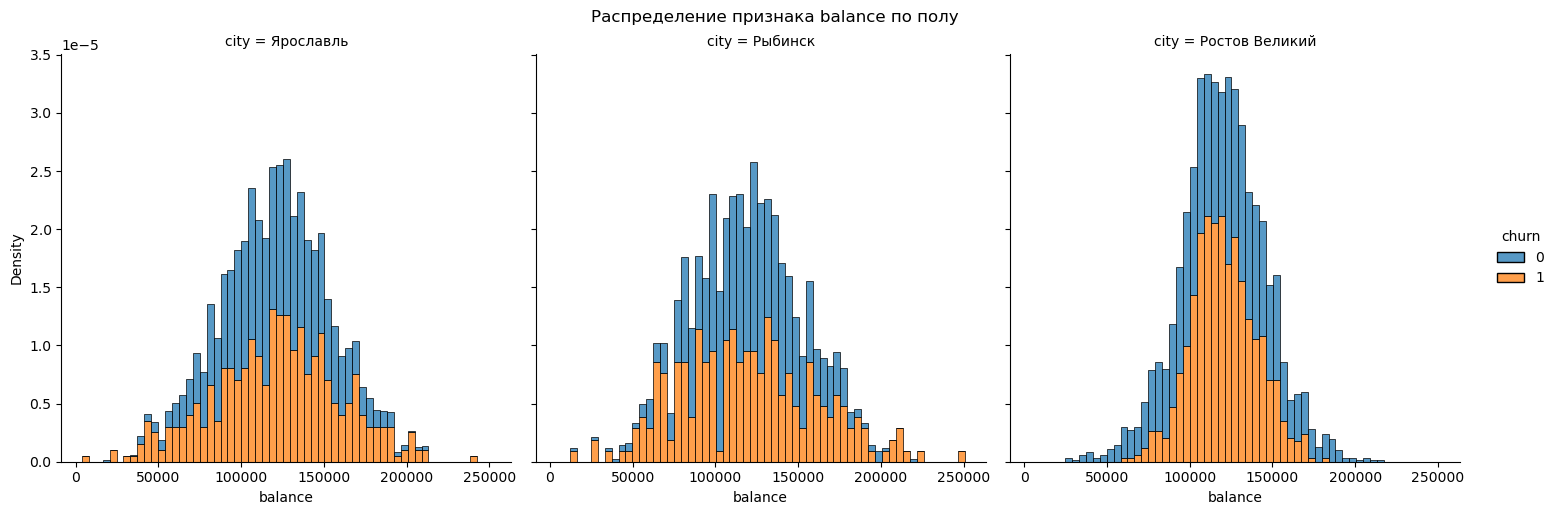

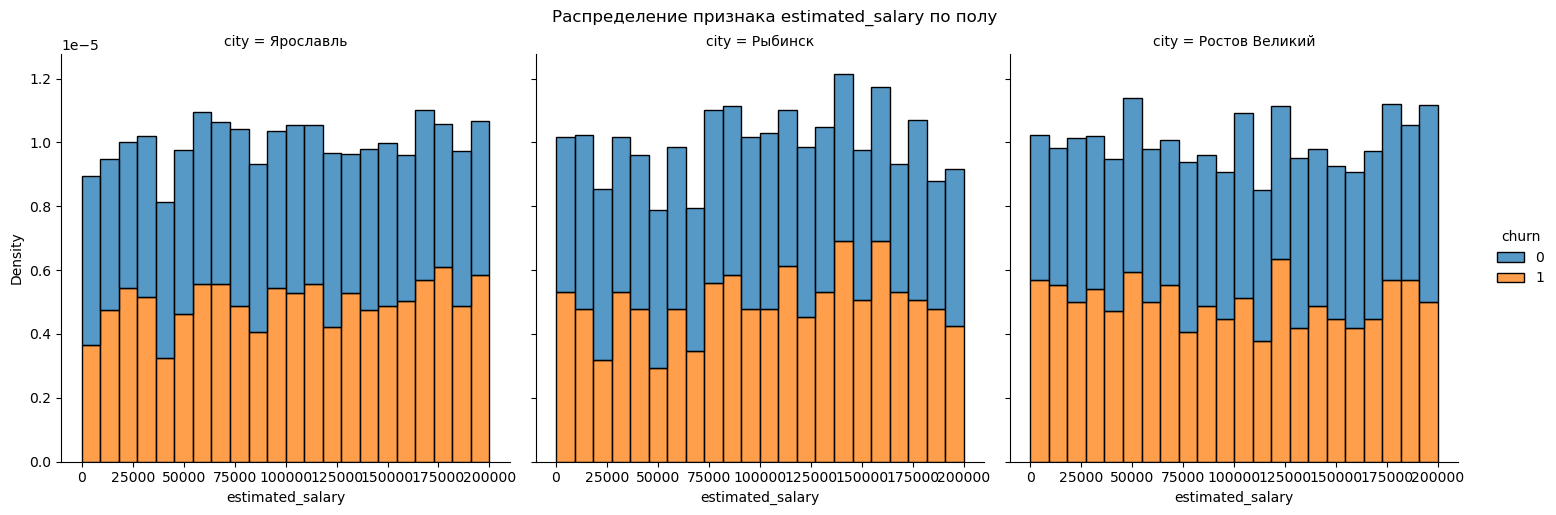

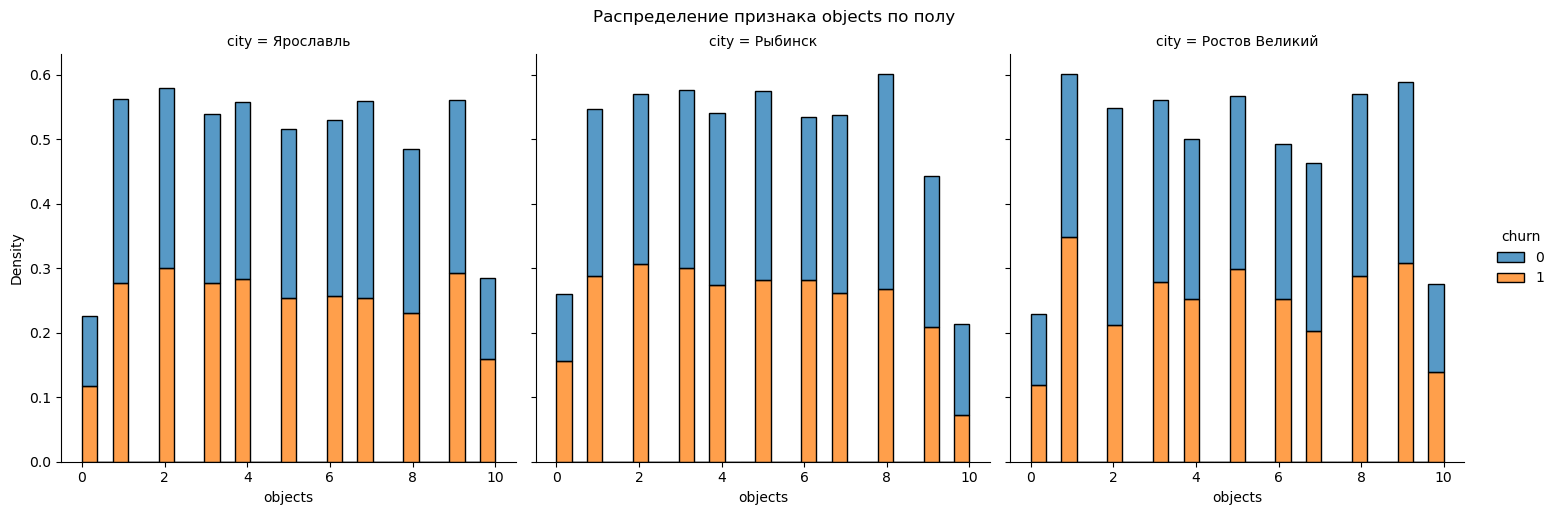

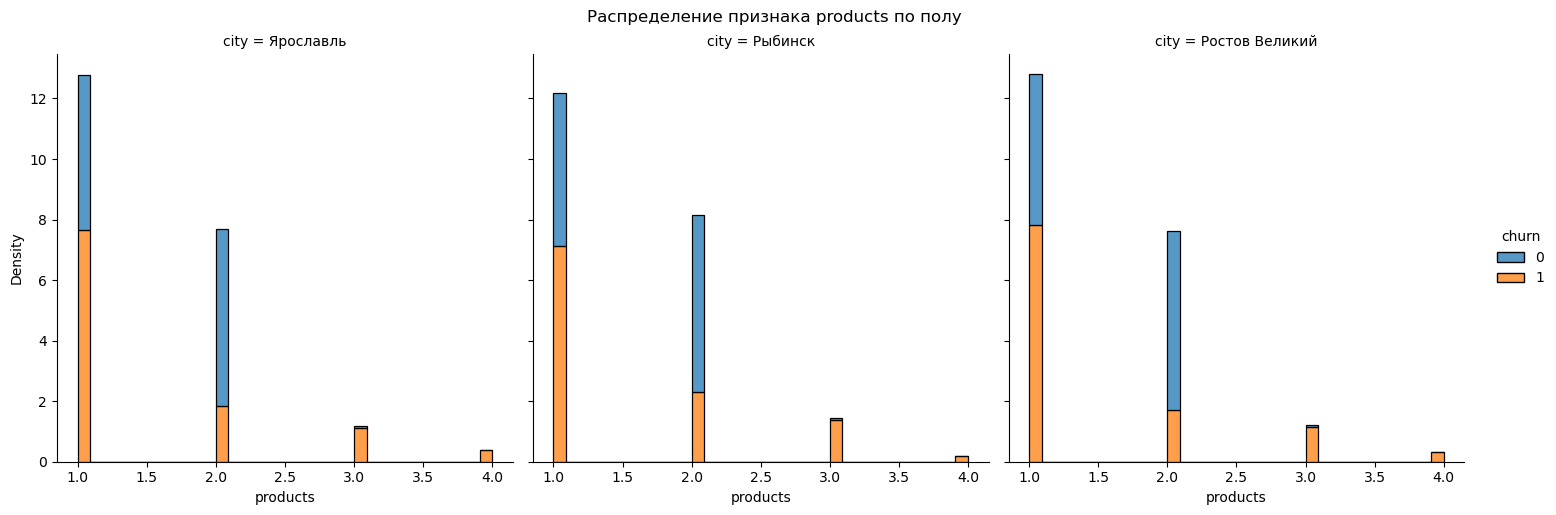

In [20]:
# строим гистограммы распределения 
columns_histplot = ['score', 'age', 'balance', 'estimated_salary', 'objects', 'products']
for column in columns_histplot :  
    sb.displot(df,x=column,hue='churn',multiple="stack", col = 'city',stat = 'density', common_norm = False) 
    plt.suptitle(f"Распределение признака {column} по полу", y=1.02)
    plt.xlabel(column)
    plt.ylabel('Доля клиентов')
    plt.show()

По графикам можно сделать следующие выводы:
- во всех городах преобладают клиенты с рейтингом в диапазоне 600-700, в обеих группах клиентов
- уходят преимущественно клиенты 40-50 лет, среди не отточных преобладают клиенты возраста 30 - 40 лет
- средний баланс на карте в пределах 100 - 150 тыс, клиенты с балансом более 200 тыс. преимущественно уходят в отток, во всех городах кроме Ростова Великого
- в Ростове Великом и Ярославле большое количество клиентов с количеством объектов недвижимости около 10, что сложно как-то объянить
- больше половины пользователей с 1 продуктом уходят в Ярославле, так же большой отток среди пользователей 3-4 продуктов

### Анализ оттока в разрезе пола

In [21]:
# сводная таблица по полу
df.pivot_table(index='gender', columns='churn',values='user_id',aggfunc='count')

churn      0     1
gender            
Ж       3404  1139
М       4559   898

Как и было выявлено ранее среди клиентов банка больше мужчин, однако отток больше у женщин

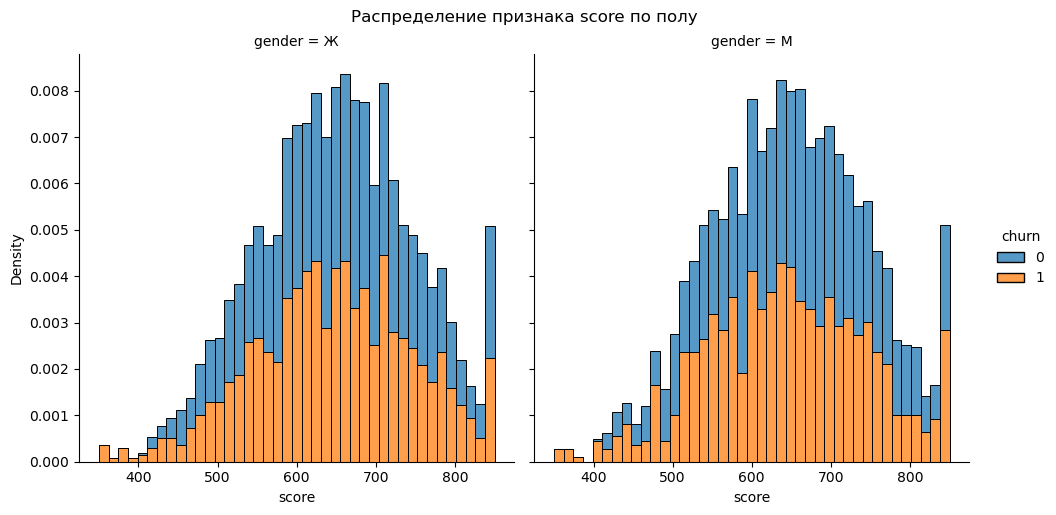

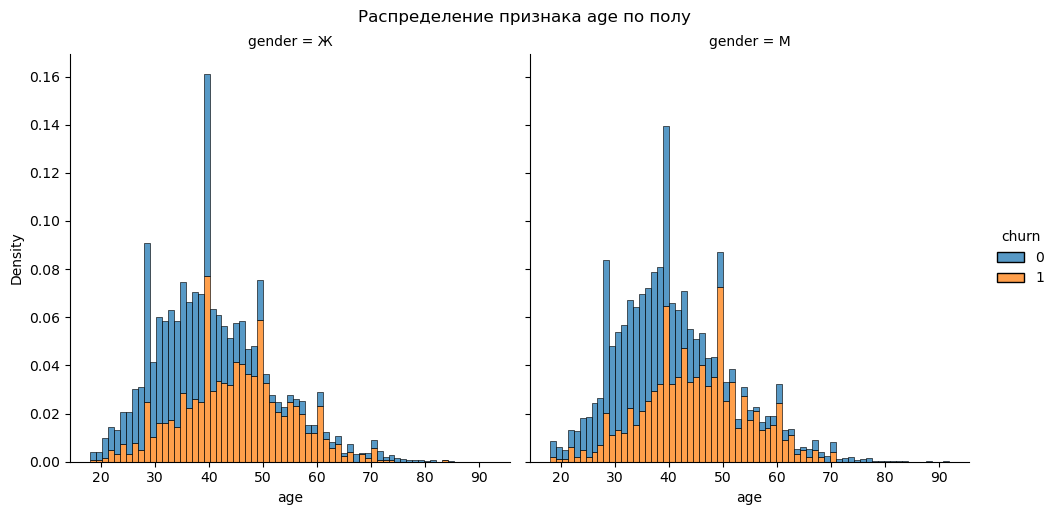

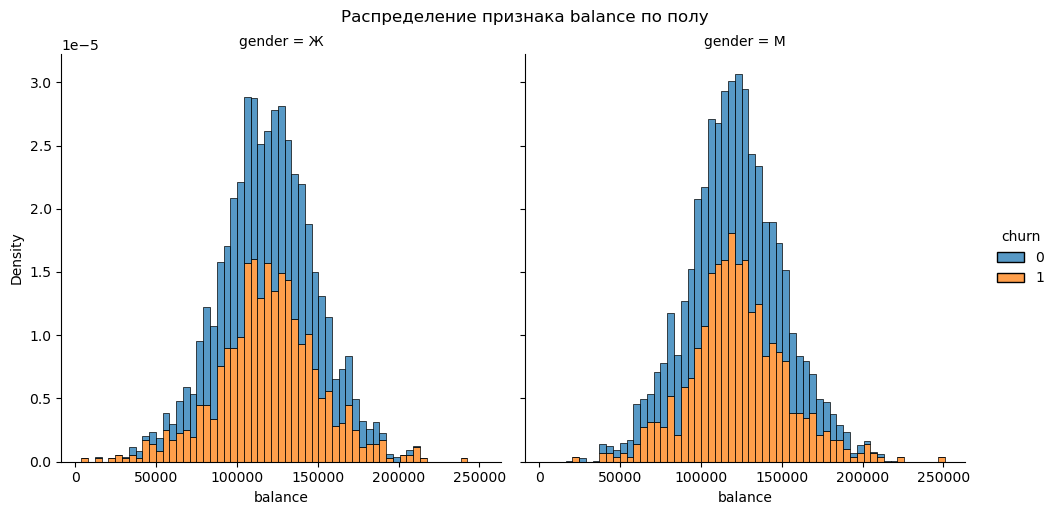

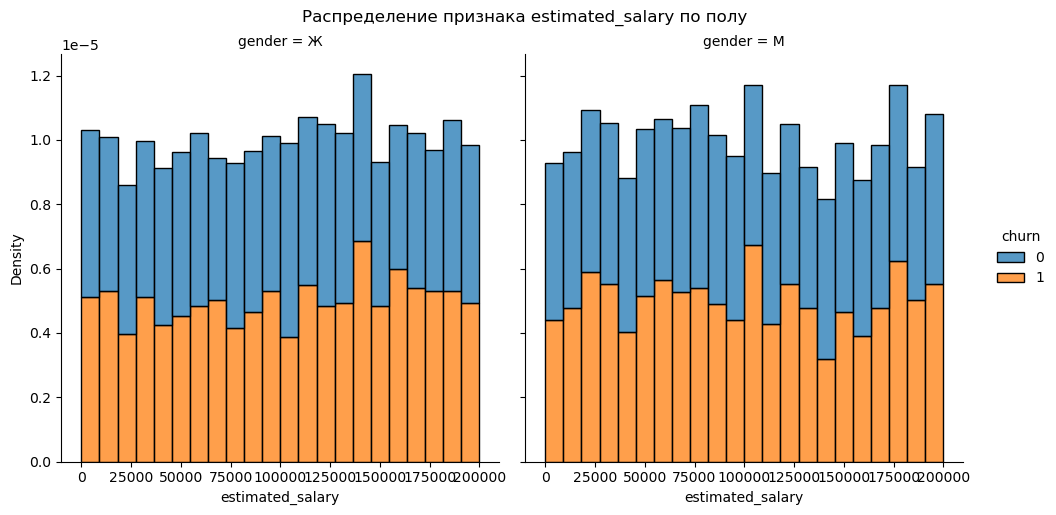

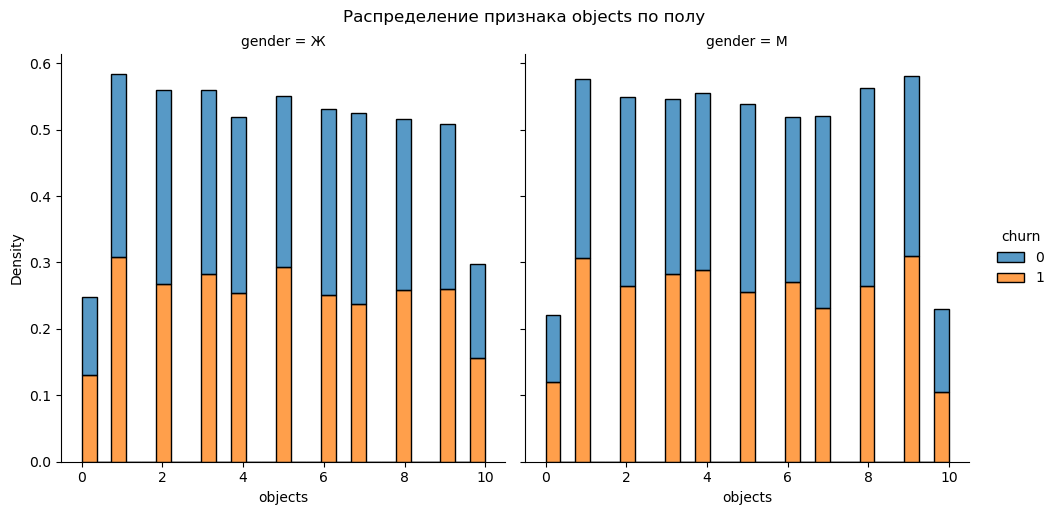

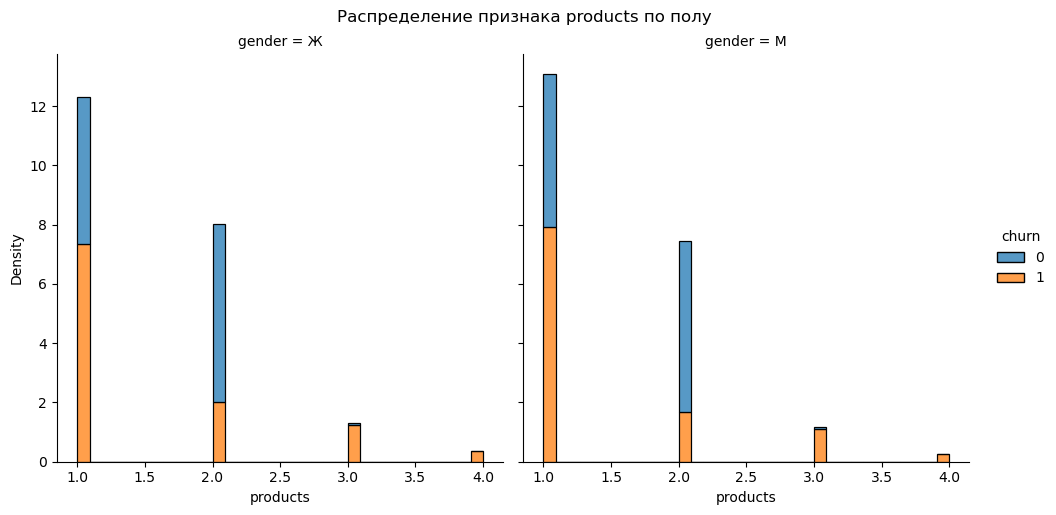

In [22]:
# строим гистограммы распределения 
columns_histplot = ['score', 'age', 'balance', 'estimated_salary', 'objects', 'products']
for column in columns_histplot :  # проходим по всем колонкам из списка
    sb.displot(df,x=column,hue='churn',multiple="stack", col = 'gender',stat = 'density', common_norm = False) 
    plt.suptitle(f"Распределение признака {column} по полу", y=1.02)
    plt.xlabel(column)
    plt.ylabel('Доля клиентов')
    plt.show()

По графикам можно сделать следующие выводы:

- аналагочино ситуации с городами преобладают клиенты с рейтингом в диапазоне 600-700, в обеих группах клиентов
- чаще уходят клиенты  в возрасте 40-50 независимо от пола, причем в обеих круппах наблюдаются пики на гранцах диапазона
- количество объектов недвижимости не сильно влияет на отток, независимо от пола
- средний баланс на карте в пределах 100 - 150 тыс, клиенты с балансом более 200 тыс. преимущественно уходят в отток независимо от пола
- чаще всего уходят клиенты пользующиеся только одним продуктом

### Анализ оттока клиентов в возрасте 40 - 50 лет

In [23]:
# делаем срез по возрасту
df_age = df.query('40 <= age <= 50') 

In [24]:
print('Клиентов в возрасте 40 - 50 лет', df_age['age'].count()/ df['age'].count()*100, '% от общего количества')

Клиентов в возрасте 40 - 50 лет 27.52 % от общего количества


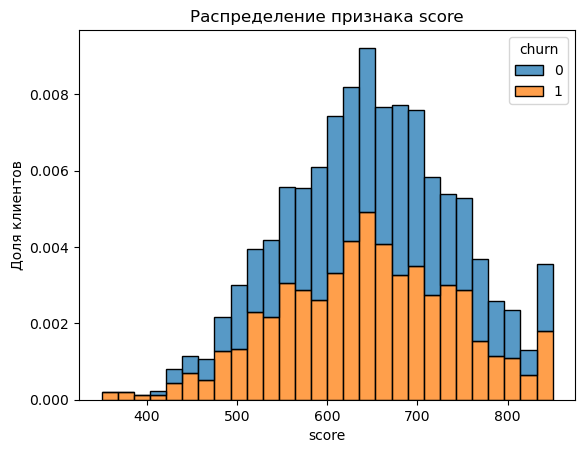

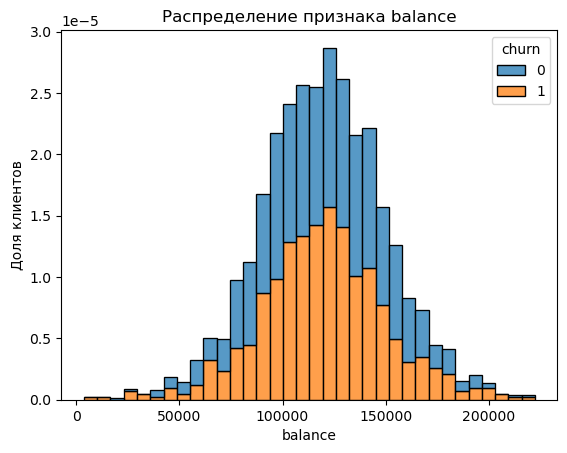

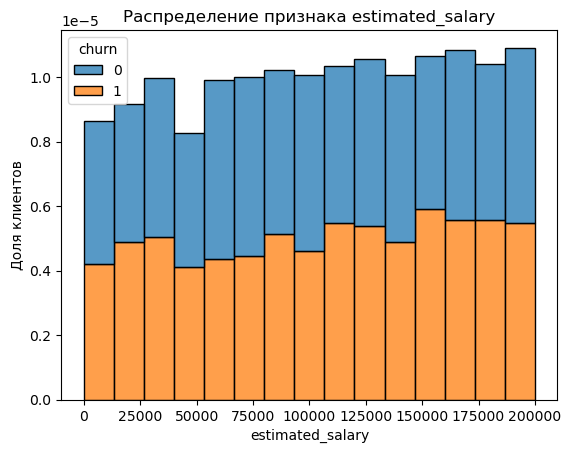

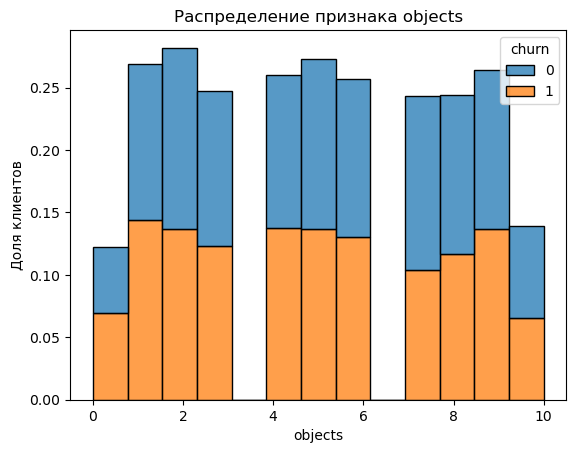

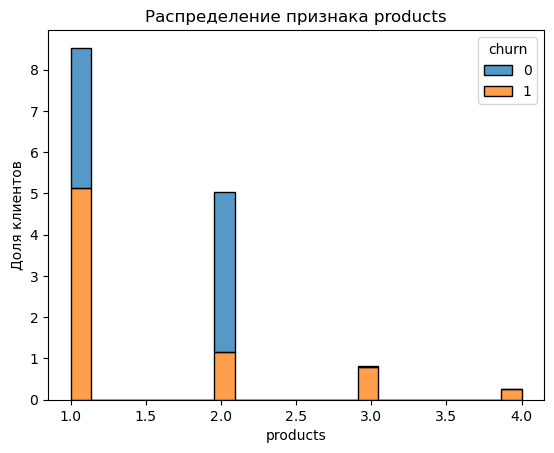

In [25]:
# строим гистограммы распределения 
columns_histplot = ['score', 'balance', 'estimated_salary', 'objects', 'products']
for column in columns_histplot :  
    sb.histplot(data = df_age,x=column,hue='churn',multiple="stack", stat = 'density', common_norm = False) 
    plt.title(f"Распределение признака {column}")
    plt.xlabel(column)
    plt.ylabel('Доля клиентов')
    plt.show()

По графикам можно сделать следующие выводы:

- распределение по рейтингу аналогично выявленному ранее - преобладлают клиенты с рейтингом 600-700 в обеих группах
- преобладают колиенты с  4-6 объектами недвижимости
- отток более 50% от пользователей 1 продукта и практически все пользователи у которых 3-4 продуктов

### Анализ оттока в зависимости от количества продуктов

In [26]:
# сводная таблица по городам
df_products = df.pivot_table(index='products', columns='churn',values='user_id',
                             aggfunc='count').sort_values(by = 1, ascending = False).reset_index()

# находим относительное значение
df_products['%'] = round(df_products[1] /  (df_products[0]+df_products[1]),2)
df_products

churn  products       0       1     %
0             1  3675.0  1409.0  0.28
1             2  4242.0   348.0  0.08
2             3    46.0   220.0  0.83
3             4     NaN    60.0   NaN

Мы видим что уходят порядка 28% пользователей с 1 продуктом, 83% пользователя с 3 продуктами, и все пользователи с 4 продуктами

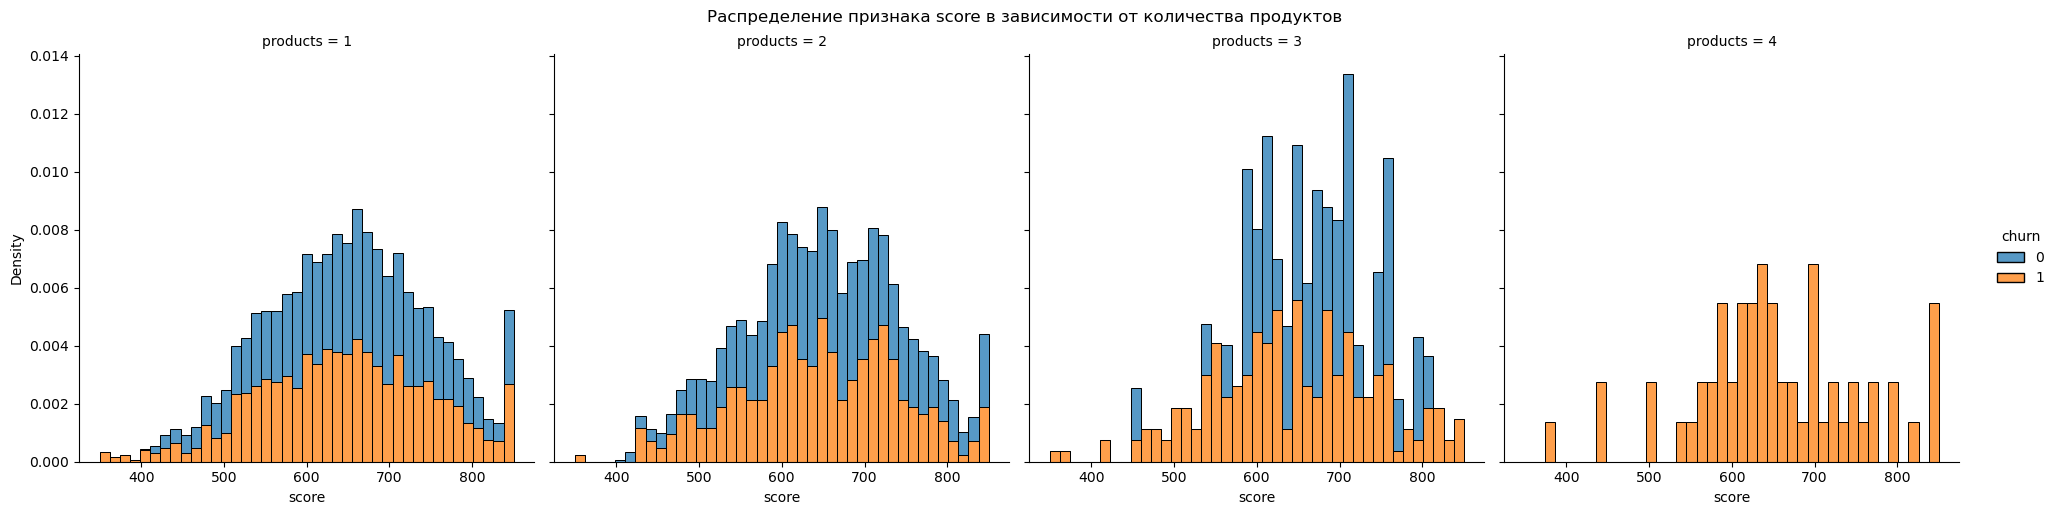

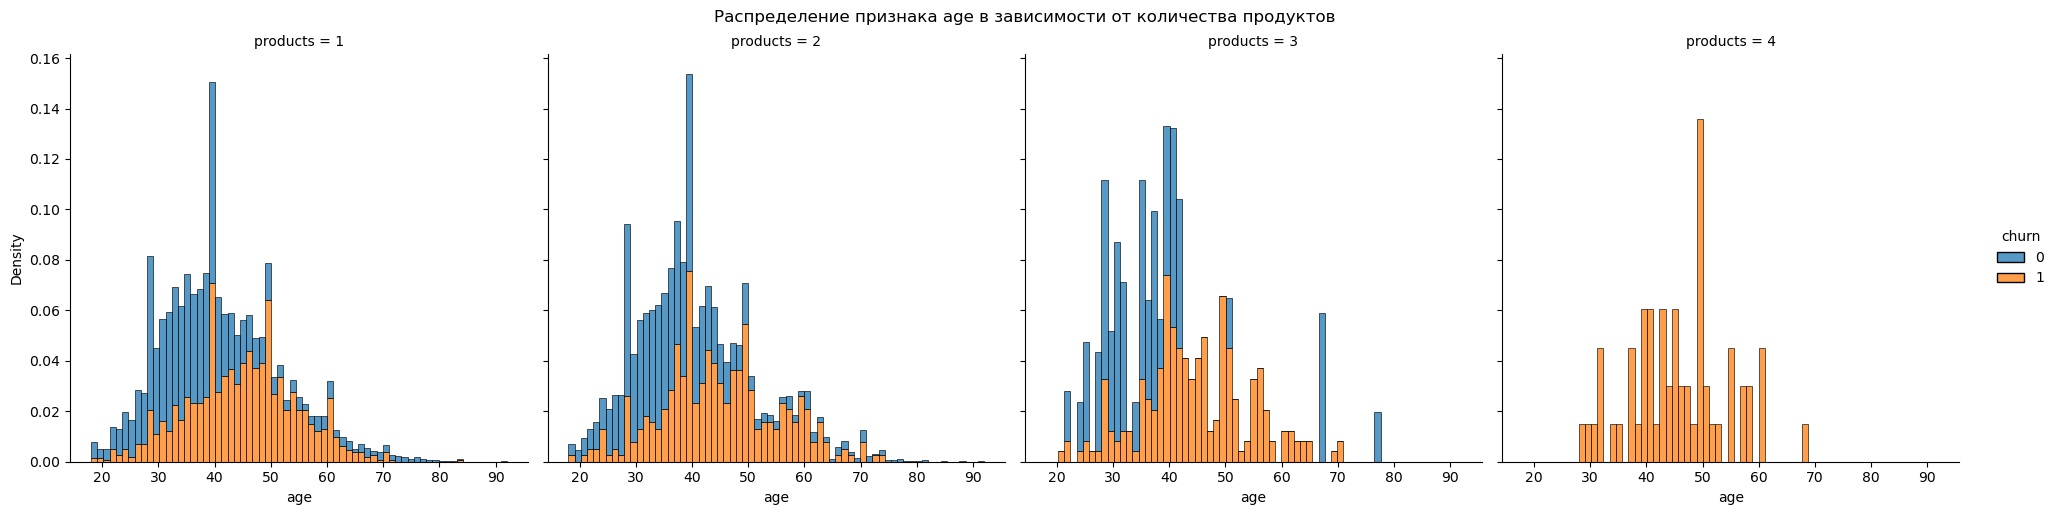

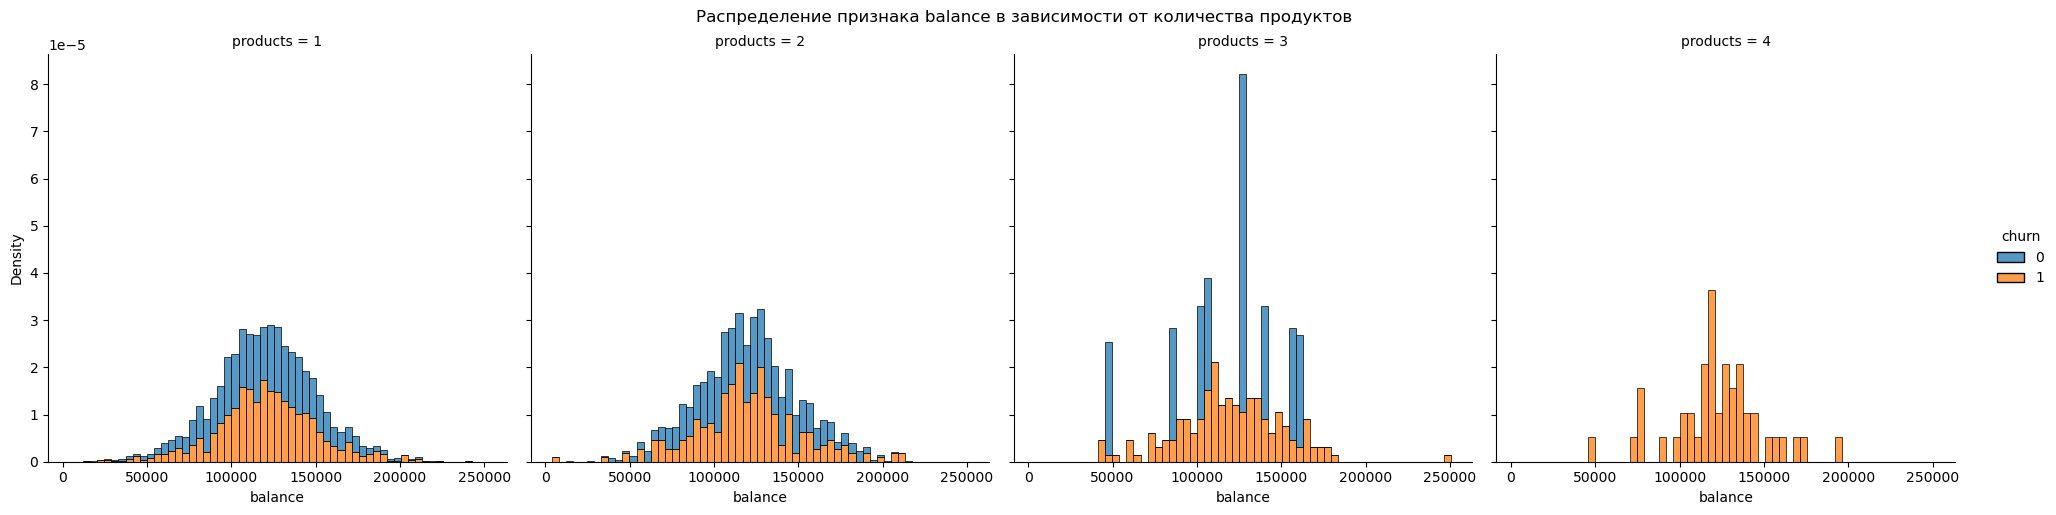

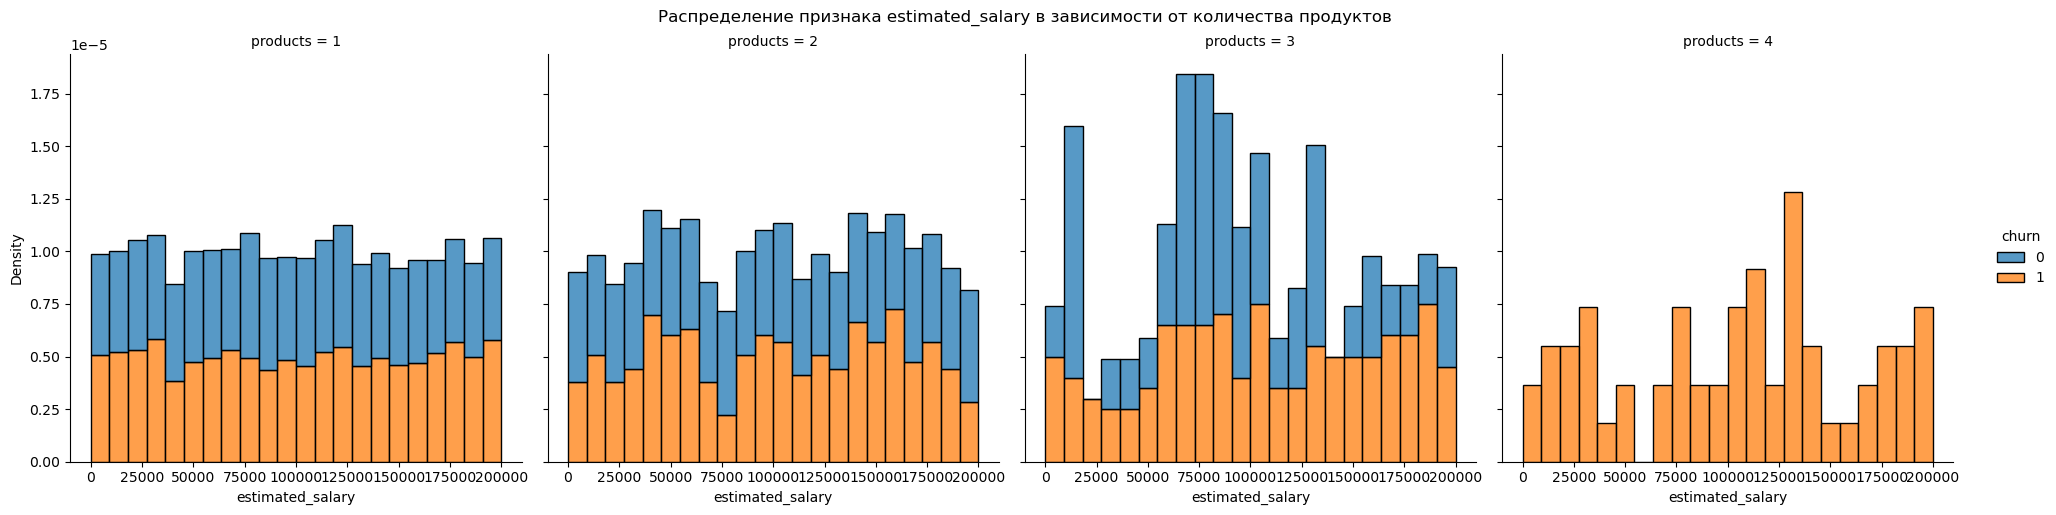

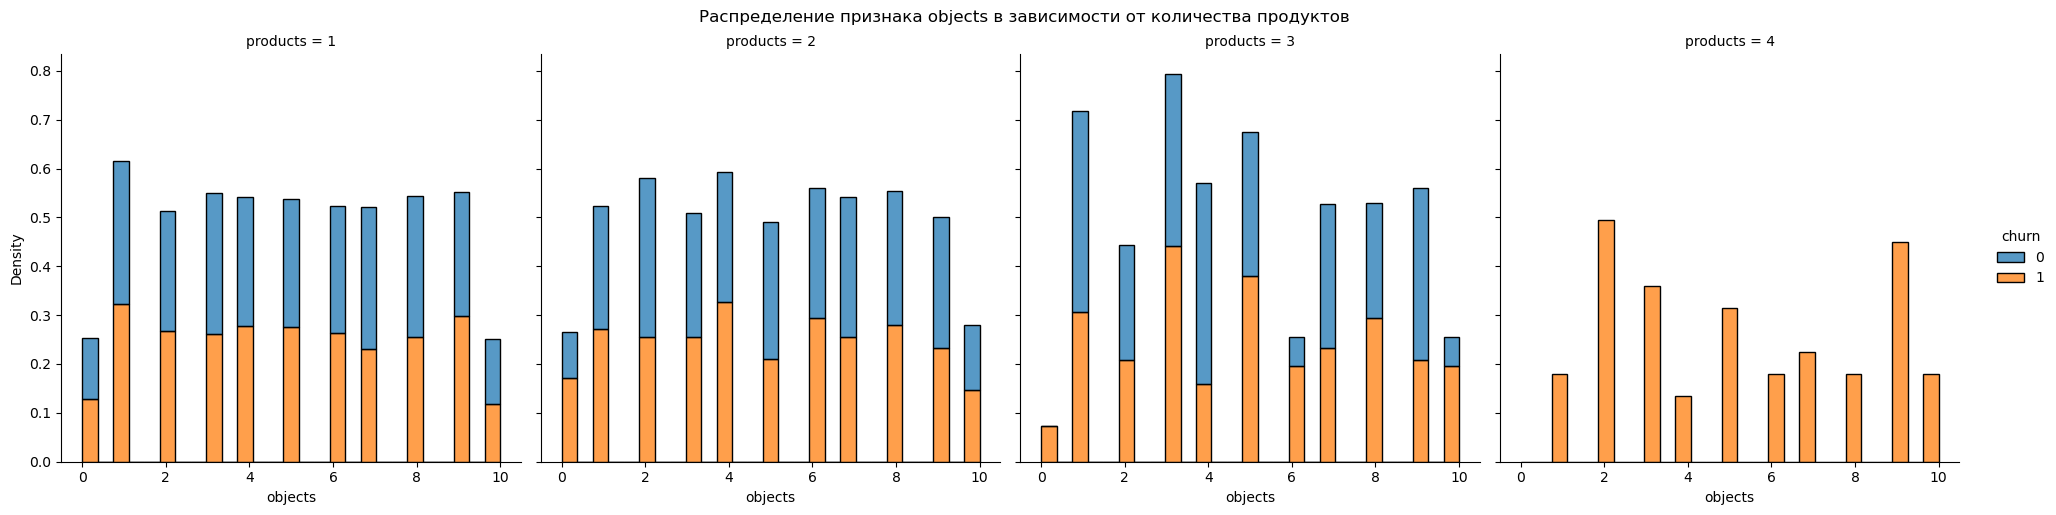

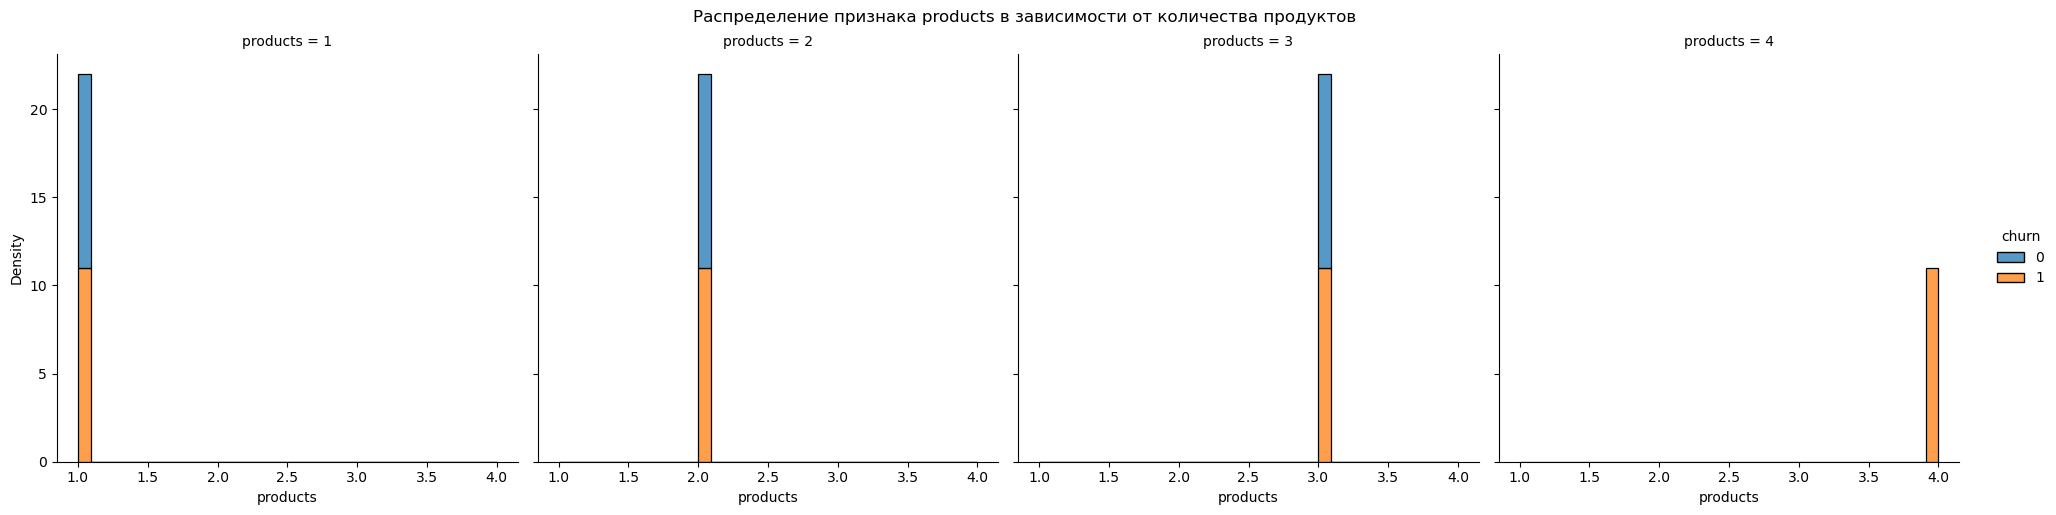

In [27]:
# строим гистограммы распределения 
columns_histplot = ['score', 'age', 'balance', 'estimated_salary', 'objects', 'products']
for column in columns_histplot : 
    sb.displot(df,x=column,hue='churn',multiple="stack", col = 'products',stat = 'density', common_norm = False) 
    plt.suptitle(f"Распределение признака {column} в зависимости от количества продуктов", y=1.02)
    plt.xlabel(column)
    plt.ylabel('Доля клиентов')
    plt.show()


По графикам можно сделать следующие выводы:

- клиентов  с 4 продуктами можно отнести к отточным независимо от остальных параметров
- клиенты с 3 продуктами старше 40 лет преимущественно отточные
- в остальном прослеживается выявленная ранее динамика

### Вывод по разделу

Итак, на основании проделанной ранее работы можно дать следующие хариактеристики:

Портрет клиента склонного к оттоку:
- скорринговый бал 400 и ниже
- женщина
- возраст 40-50 лет
- с балансом более 200 тыс. 
- проживает в Ростове Великом
- пользуется 1, либо 3-4 продуктмии банка
- не является активным пользователем

Портрет надежного клиента:
- скорринговый бал в диапазоне 600-700
- мужчина
- возраст 30 - 40 лет
- пользуется 2 продуктами банка
- проживает в Ярославле 
- является активным пользователем

## Проверка статистических гипотез

### Гипотеза №1

Проверка гипотез начинается с формулировки нулевой гипотезы H₀. 
H₀ всегда формулируется так, чтобы использовать знак равенства.  
Исходя из H₀ формулируется альтернативная гипотеза H₁. Это утверждение, которое принимается верным, если отбрасывается H₀.


Сформулируем нулевую и анльтернативную гипотезы:

Нулевая гипотеза: Средний доход в группах с оттоком и без одинаковый

Альтернативная гипотеза: Средний доход в группах с оттоком отличается от среднего дохода в группе без оттока
    

In [28]:
# формируем срезы по клиентам
df_churn = df.query('churn == 1')
df_active = df.query('churn == 0')

Мы хотим сравнить среднее двух генеральных совокупностей. Рассмотрим три аспекта, которые надо проверить, чтобы понять, можно ли применять t-тест: 
- Генеральные совокупности не должны зависеть друг от друга
- Выборочные средние должны быть нормально распределены
- Дисперсии рассматриваемых генеральных совокупностей должны быть равны

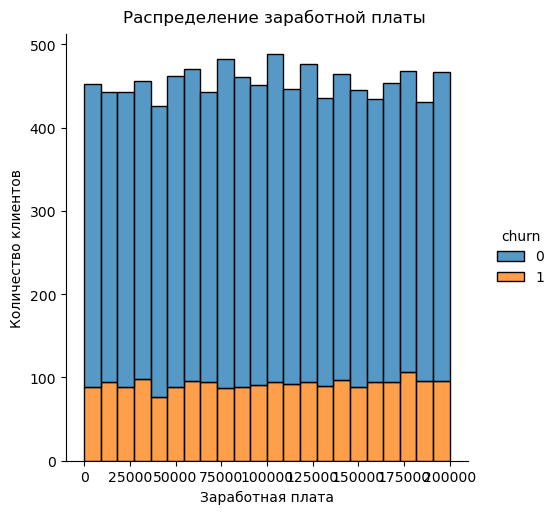

In [29]:
# строим гистограммы распределения 
sb.displot(df,x='estimated_salary',hue='churn',multiple="stack") 
plt.suptitle("Распределение заработной платы", y=1.02)
plt.xlabel('Заработная плата')
plt.ylabel('Количество клиентов')
plt.show()

Распределение сложно назвать нормальным , данные распределены слишком равномерно 

In [30]:
# рассчитаем дисперсию
print('Дисперсия ушедних:',df_churn['estimated_salary'].var()) 
print('Дисперсия оставшихся:',df_active['estimated_salary'].var())

Дисперсия ушедних: 3353848166.807016
Дисперсия оставшихся: 3295401414.9183917


Дисперсии сопоставимы, но не равны поэтому при вызове метода scipy.stats.ttest_ind() укажем equal_var= False 

In [31]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(df_churn['estimated_salary'], df_active['estimated_salary'], equal_var= False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.22892461305145798
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть нулевую гипотезу, соответственно cредний доход в группах с оттоком и без одинаков.

### Гипотеза №2

Нулевая гипотеза: Средний возраст в группах с оттоком и без одинаковый

Альтернативная гипотеза: Средний возраст в группах с оттоком отличается от среднего возраста в группе без оттока

In [32]:
# рассчитаем дисперсию
print('Дисперсия ушедних:',df_churn['age'].var())
print('Дисперсия оставшихся:',df_active['age'].var())

Дисперсия ушедних: 95.28808400195481
Дисперсия оставшихся: 102.52297408041896


Поскольку дисперсии не равны используем тот же подход что и при проверке гипотезы равенства дохода, при вызове метода scipy.stats.ttest_ind() укажем equal_var= False 

In [33]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(df_churn['age'], df_active['age'], equal_var= False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 4.7127272656641046e-179
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу, cредний возраст в группах с оттоком отличается от среднего возраста в группе без оттока

### Гипотеза № 3

Нулевая гипотеза: Количество продуктов в группах с оттоком и без одинаково

Альтернативная гипотеза: Количество продуктов в группах с оттоком отличается от количества продуктов в группе без оттока

In [34]:
# рассчитаем дисперсию
print('Дисперсия ушедних:',df_churn['products'].var())
print('Дисперсия оставшихся:',df_active['products'].var())

Дисперсия ушедних: 0.6424351848368853
Дисперсия оставшихся: 0.2596264505553961


Поскольку дисперсии не равны при вызове метода scipy.stats.ttest_ind() укажем equal_var= False 

In [35]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(df_churn['products'], df_active['products'], equal_var= False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.00021858494460549394
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу, количество продуктов в группах с оттоком отличается от количества продуктов в группе без оттока

Мы проверили несколько гипотез и выяснили следующее:
- cредний доход в группах с оттоком и без одинаков
- cредний возраст в группах с оттоком отличается от среднего возраста в группе без оттока
- количество продуктов в группах с оттоком отличается от количества продуктов в группе без оттока

## Выводы

Мы проанализировали данные клиентов банка «Метанпромбанк», перед тем как приступить к анализу данных выполнили предобработку, изучили имеющиеся данные. 

В ходе анализа выяснилось что за месяц ушло 20,4% клиентов, это достаточно большой показатель. 
Были составлены следующие портреты клиентов 

Портрет клиента склонного к оттоку:
- скорринговый бал 400 и ниже
- женщина
- возраст 40-50 лет
- с балансом более 200 тыс. 
- проживает в Ростове Великом
- пользуется 1, либо 3-4 продуктмии банка
- не является активным пользователем

Портрет надежного клиента:
- скорринговый бал в диапазоне 600-700
- мужчина
- возраст 30 - 40 лет
- пользуется 2 продуктами банка
- проживает в Ярославле 
- является активным пользователем

Мы проверили несколько гипотез и выяснили следующее:
- cредний доход в группах с оттоком и без одинаков
- cредний возраст в группах с оттоком отличается от среднего возраста в группе без оттока
- количество продуктов в группах с оттоком отличается от количества продуктов в группе без оттока

По результатам проделанной работы можно дать следующие рекомендации:
- можно предложить дополнительный кешбек, думаю это заинтиресует клиентов женского пола. Так же можно рассмотреть возможность партнерских программ и как следствие дополнительных скидок у магазинов-партнеров. 
- в Ростове Великом очень большое количество отточных клиентов, думаю имеет смысл провести дополнительный анализ. Может есть проблемы с качеством предоставляемых услуг
- клиентам с 1 продуктом постараться предложить дополнительные продукты банка которые могут их заинтересовать
